In [1]:
!git clone https://github.com/benmoseley/FBPINNs

fatal: destination path 'FBPINNs' already exists and is not an empty directory.


In [2]:
%cd FBPINNs

/content/FBPINNs


In [3]:
!pip install -e .

Obtaining file:///content/FBPINNs
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for fbpinns (pyproject.toml) ... done
  Created wheel for fbpinns: filename=fbpinns-0.2.0-py3-none-any.whl size=7355 sha256=a4e8d7af79df6c54cff68d5eca180b4e2db3e43c328fb724e324a6cefa6d1252
  Stored in directory: /tmp/pip-ephem-wheel-cache-v6whmzeb/wheels/93/ba/fc/aa15567498b2231183d376dfbb919386ad1819f88a00c79e5d
Successfully built fbpinns
  Attempting uninstall: fbpinns
    Found existing installation: fbpinns 0.2.0
    Uninstalling fbpinns-0.2.0:
      Successfully uninstalled fbpinns-0.2.0


In [4]:
import numpy as np
from fbpinns.domains import RectangularDomainND

domain = RectangularDomainND
domain_init_kwargs = dict(
    xmin=np.array([0.,]),
    xmax=np.array([1.,]),# solve the problem over the domain [0, 1]
)

In [5]:
import jax.numpy as jnp
from fbpinns.problems import Problem

In [6]:
class HarmonicOscillator1D(Problem):
    """Solves the time-dependent damped harmonic oscillator
          d^2 u      du
        m ----- + mu -- + ku = 0
          dt^2       dt

        Boundary conditions:
        u (0) = 1
        u'(0) = 0
    """

    @staticmethod
    def init_params(d=2, w0=20):

        mu, k = 2*d, w0**2

        static_params = {
            "dims":(1,1),
            "d":d,
            "w0":w0,
            "mu":mu,
            "k":k,
            }

        return static_params, {}

    @staticmethod
    def sample_constraints(all_params, domain, key, sampler, batch_shapes):

        # physics loss
        x_batch_phys = domain.sample_interior(all_params, key, sampler, batch_shapes[0])
        required_ujs_phys = (
            (0,()),
            (0,(0,)),
            (0,(0,0))
        )

        # boundary loss
        x_batch_boundary = jnp.array([0.]).reshape((1,1))
        u_boundary = jnp.array([1.]).reshape((1,1))
        ut_boundary = jnp.array([0.]).reshape((1,1))
        required_ujs_boundary = (
            (0,()),
            (0,(0,)),
        )

        return [[x_batch_phys, required_ujs_phys], [x_batch_boundary, u_boundary, ut_boundary, required_ujs_boundary]]

    @staticmethod
    def loss_fn(all_params, constraints):

        mu, k = all_params["static"]["problem"]["mu"], all_params["static"]["problem"]["k"]

        # physics loss
        _, u, ut, utt = constraints[0]
        phys = jnp.mean((utt + mu*ut + k*u)**2)

        # boundary loss
        _, uc, utc, u, ut = constraints[1]
        boundary = 1e6*jnp.mean((u-uc)**2) + 1e2*jnp.mean((ut-utc)**2)

        return phys + boundary

    @staticmethod
    def exact_solution(all_params, x_batch, batch_shape=None):

        d, w0 = all_params["static"]["problem"]["d"], all_params["static"]["problem"]["w0"]

        w = jnp.sqrt(w0**2-d**2)
        phi = jnp.arctan(-d/w)
        A = 1/(2*jnp.cos(phi))
        cos = jnp.cos(phi + w * x_batch)
        exp = jnp.exp(-d * x_batch)
        u = exp * 2 * A * cos

        return u

problem = HarmonicOscillator1D
problem_init_kwargs=dict(
    d=2, w0=80,# define the ODE parameters
)

In [7]:
from fbpinns.decompositions import RectangularDecompositionND

decomposition = RectangularDecompositionND# use a rectangular domain decomposition
decomposition_init_kwargs=dict(
    subdomain_xs=[np.linspace(0,1,15)],# use 15 equally spaced subdomains
    subdomain_ws=[0.15*np.ones((15,))],# with widths of 0.15
    unnorm=(0.,1.),# define unnormalisation of the subdomain networks
)

In [8]:
from fbpinns.networks import FCN

network = FCN# place a fully-connected network in each subdomain
network_init_kwargs=dict(
    layer_sizes=[1,32,1],# with 2 hidden layers
)

In [9]:
from fbpinns.constants import Constants

c = Constants(
    domain=domain,
    domain_init_kwargs=domain_init_kwargs,
    problem=problem,
    problem_init_kwargs=problem_init_kwargs,
    decomposition=decomposition,
    decomposition_init_kwargs=decomposition_init_kwargs,
    network=network,
    network_init_kwargs=network_init_kwargs,
    ns=((200,),),# use 200 collocation points for training
    n_test=(500,),# use 500 points for testing
    n_steps=20000,# number of training steps
    clear_output=True,
)

print(c)

run: test
domain: <class 'fbpinns.domains.RectangularDomainND'>
domain_init_kwargs: {'xmin': array([0.]), 'xmax': array([1.])}
problem: <class '__main__.HarmonicOscillator1D'>
problem_init_kwargs: {'d': 2, 'w0': 80}
decomposition: <class 'fbpinns.decompositions.RectangularDecompositionND'>
decomposition_init_kwargs: {'subdomain_xs': [array([0.        , 0.07142857, 0.14285714, 0.21428571, 0.28571429,
       0.35714286, 0.42857143, 0.5       , 0.57142857, 0.64285714,
       0.71428571, 0.78571429, 0.85714286, 0.92857143, 1.        ])], 'subdomain_ws': [array([0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15,
       0.15, 0.15, 0.15, 0.15])], 'unnorm': (0.0, 1.0)}
network: <class 'fbpinns.networks.FCN'>
network_init_kwargs: {'layer_sizes': [1, 32, 1]}
n_steps: 20000
scheduler: <class 'fbpinns.schedulers.AllActiveSchedulerND'>
scheduler_kwargs: {}
ns: ((200,),)
n_test: (500,)
sampler: grid
optimiser: <function adam at 0x7f3d68e137f0>
optimiser_kwargs: {'learning_rate': 0.00

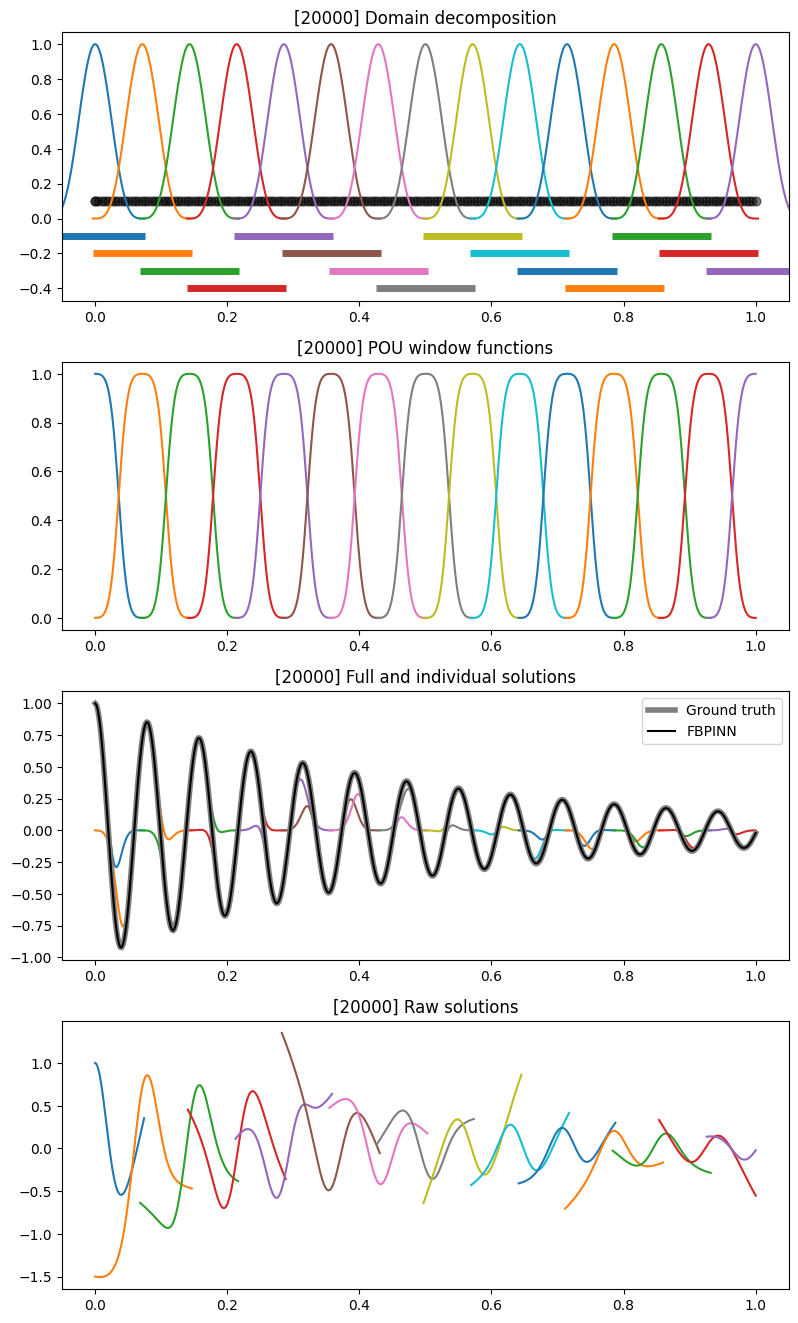

[INFO] 2023-08-18 06:08:55 - [i: 20000/20000] Training complete


In [10]:
from fbpinns.trainers import FBPINNTrainer

run = FBPINNTrainer(c)
all_params = run.train()